# Perform a looping with the quadrotor

In [2]:
# Import Necessary Libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import IPython
import gc

from scipy.linalg import block_diag
from scipy import sparse

from qpsolvers import solve_qp, Problem, solve_problem

import quadrotor


# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [3]:
#initialisation
m=quadrotor.MASS
r=quadrotor.LENGTH
Ine=quadrotor.INERTIA
dt=quadrotor.DT
xdim=quadrotor.DIM_STATE
udim=quadrotor.DIM_CONTROL
grav=quadrotor.GRAVITY_CONSTANT
# iterations = 2 # number of steps
# nvars = iterations*udim + (iterations+1)*xdim # total number of variables

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)
print("gravity constant =", quadrotor.GRAVITY_CONSTANT)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2
gravity constant = 9.81


___________________________________________________________________________________________

## <u>Part 1 - Setting up the trajectory Optimization (50 points)</u>
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)

---


##### Given:
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta =>\dot{v}_x= - (u_1 + u_2) \frac{\sin \theta}{m}\\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g=>\dot{v}_y= (u_1 + u_2) \frac{\cos \theta}{m} -g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2)=> \dot{\omega} = \frac{r}{I}(u_1 - u_2) \end{align}$$


##### Rewriting:
$$\begin{align} 
\dot{p_x} &= v_x\\
\dot{p_y} &= v_y\\
\dot{\theta} &= \omega\\
\dot{\omega} &= \frac{r}{I}(u_1 - u_2)\\
\dot{v}_x &= - (u_1 + u_2) \frac{\sin \theta}{m}\\ 
\dot{v}_y &= (u_1 + u_2) \frac{\cos \theta}{m} -g \end{align}$$


##### Discretizing:
$$\begin{align} 
({p_x})_{n+1} &= ({p_x})_{n}+ \Delta t ({v_x})_{n}\\
({p_y})_{n+1} &= ({p_y})_{n}+ \Delta t ({v_y})_{n}\\
{\theta}_{n+1} &= {\theta}_{n}+ \Delta t {\omega}_{n}\\
{\omega}_{n+1} &= {\omega}_{n}+ \frac{r.\Delta t}{I}(u_1)_n-\frac{r.\Delta t}{I}(u_2)_n\\
({v_x})_{n+1} &=  ({v_x})_{n} - [(u_1)_n + (u_2)_n] \frac{\sin \theta \Delta t}{m}\\ 
({v_y})_{n+1} &=  ({v_y})_{n} + [(u_1)_n + (u_2)_n] \frac{\cos \theta \Delta t}{m}-g\Delta t \end{align}$$


But both $\sin$ and $\cos$ are non-linear function. Therfore we have to convert to $1^{st}$ order linear functions for which we make use of <u>Taylor's Series of Expansion</u> which gives as follows:


$$
\sin(\theta_n) \approx \sin\left(\bar{\theta}_n\right) + \cos\left(\bar{\theta}_n\right) \Delta \theta_n\\
\cos(\theta_n) \approx \cos\left(\bar{\theta}_n\right) - \sin\left(\bar{\theta}_n\right) \Delta \theta_n
$$

Using these we convert our $({v_x})_{n+1}$ and $({v_y})_{n+1}$ as:
$$\begin{align}
({v_x})_{n+1} &=  ({v_x})_{n} - [(u_1)_n + (u_2)_n] \frac{(\sin\left(\bar{\theta}_n\right) + \cos\left(\bar{\theta}_n\right) \Delta \theta_n) \Delta t}{m}\\ 
&= ({v_x})_{n} -(u_1)_n \frac{\Delta t}{m}\sin\left(\bar{\theta}_n\right)-(u_1)_n \frac{\Delta t}{m}\cos\left(\bar{\theta}_n\right) \Delta \theta_n-(u_2)_n \frac{\Delta t}{m}\sin\left(\bar{\theta}_n\right)-(u_2)_n \frac{\Delta t}{m}\cos\left(\bar{\theta}_n\right) \Delta \theta_n\\
&= ({v_x})_{n} -(u_1)_n \frac{\Delta t}{m}\cos\left(\bar{\theta}_n\right) \Delta \theta_n-(u_2)_n \frac{\Delta t}{m}\cos\left(\bar{\theta}_n\right) \Delta \theta_n\\
({v_y})_{n+1} &=  ({v_y})_{n} + [(u_1)_n + (u_2)_n] \frac{(\cos\left(\bar{\theta}_n\right) - \sin\left(\bar{\theta}_n\right) \Delta \theta_n) \Delta t}{m}-g\Delta t\\
&= ({v_y})_{n} +(u_1)_n \frac{\Delta t}{m}\cos\left(\bar{\theta}_n\right)-(u_1)_n \frac{\Delta t}{m}\sin\left(\bar{\theta}_n\right) \Delta \theta_n+(u_2)_n \frac{\Delta t}{m}\cos\left(\bar{\theta}_n\right)-(u_2)_n \frac{\Delta t}{m}\sin\left(\bar{\theta}_n\right) \Delta \theta_n-g\Delta t\\
&= ({v_y})_{n}-(u_1)_n \frac{\Delta t}{m}\sin\left(\bar{\theta}_n\right) \Delta \theta_n-(u_2)_n \frac{\Delta t}{m}\sin\left(\bar{\theta}_n\right) \Delta \theta_n-g\Delta t
\end{align}$$


#### Rewriting the discretized equations:
$$
\begin{align} 
(\Delta p_x)_{n+1} &= (\Delta p_x)_{n} + \Delta t (\Delta v_x)_{n} \\
(\Delta v_x)_{n+1} &= (\Delta v_x)_{n} - (\Delta u_1)_n \frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n - (\Delta u_2)_n \frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n \\
(\Delta p_y)_{n+1} &= (\Delta p_y)_{n} + \Delta t (\Delta v_y)_{n} \\
(\Delta v_y)_{n+1} &= (\Delta v_y)_{n} - (\Delta u_1)_n \frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n - (\Delta u_2)_n \frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n - g \Delta t \\
\Delta \theta_{n+1} &= \Delta \theta_{n} + \Delta t \Delta \omega_{n} \\
\Delta \omega_{n+1} &= \Delta \omega_{n} + \frac{r \Delta t}{I} (\Delta u_1)_n - \frac{r \Delta t}{I} (\Delta u_2)_n
\end{align}
$$


#### And: 
$$
(p_x)_{0} = (v_x)_{0} = (p_y)_{0} = (v_y)_{0} = \theta_{0} = \omega_{0}  = 0 \\
(u_1)_0 = (u_2)_0 = 0
$$

#### <span style="color: red;">**Rewriting the equations in matrix form we get:**</span> 

$$
\begin{align} 
(\Delta p_x)_{n} + \Delta t (\Delta v_x)_{n} - (\Delta p_x)_{n+1} &= 0 \\
(\Delta v_x)_{n} - (\Delta u_1)_n \frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n - (\Delta u_2)_n \frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n - (\Delta v_x)_{n+1} &= 0 \\
(\Delta p_y)_{n} + \Delta t (\Delta v_y)_{n} - (\Delta p_y)_{n+1} &= 0 \\
(\Delta v_y)_{n} - (\Delta u_1)_n \frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n - (\Delta u_2)_n \frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n - g \Delta t - (\Delta v_y)_{n+1} &= 0 \\
\Delta \theta_{n} + \Delta t \Delta \omega_{n} - \Delta \theta_{n+1} &= 0 \\
\Delta \omega_{n} + \frac{r \Delta t}{I} (\Delta u_1)_n - \frac{r \Delta t}{I} (\Delta u_2)_n - \Delta \omega_{n+1} &= 0
\end{align}
$$

$$
\begin{bmatrix}
(\Delta p_x)_{n+1} \\
(\Delta v_x)_{n+1} \\
(\Delta p_y)_{n+1} \\
(\Delta v_y)_{n+1} \\
\Delta \theta_{n+1} \\
\Delta \omega_{n+1}
\end{bmatrix}
=
\underbrace{
\begin{bmatrix}
1 & \Delta t & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & \Delta t & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
}_{A}
\begin{bmatrix}
(\Delta p_x)_{n} \\
(\Delta v_x)_{n} \\
(\Delta p_y)_{n} \\
(\Delta v_y)_{n} \\
\Delta \theta_{n} \\
\Delta \omega_{n}
\end{bmatrix}
+
\underbrace{
\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 \\
-\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
-\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 \\
\frac{r \Delta t}{I} & -\frac{r \Delta t}{I} & 0 & 0 & 0 & 0
\end{bmatrix}
}_{B_{initial}}
\begin{bmatrix}
(\Delta u_1)_n\\
(\Delta u_2)_n\\
0\\
0\\
0\\
0
\end{bmatrix}
+
\begin{bmatrix}
0\\
0\\
0\\
-g \Delta t\\
0\\
0
\end{bmatrix}
$$

We have to convert the above matricular equation to $C(\bar x) \Delta x=d(\bar x)$ form:
 
Here 
$$
\Delta x=
\begin{bmatrix}
{(\Delta p_x)}_{n} \\
(\Delta v_x)_{n} \\
(\Delta p_y)_{n} \\
(\Delta v_y)_{n} \\
\Delta \theta_{n} \\
\Delta \omega_{n} \\
(\Delta u_1)_n\\
(\Delta u_2)_n\\
(\Delta p_x)_{n+1} \\
(\Delta v_x)_{n+1} \\
(\Delta p_y)_{n+1} \\
(\Delta v_y)_{n+1} \\
\Delta \theta_{n+1} \\
\Delta \omega_{n+1} \\
\end{bmatrix}
,
A = 
\begin{bmatrix}
1 & \Delta t & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & \Delta t & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1 
\end{bmatrix}
,
B =
\begin{bmatrix}
0 & 0  \\
-\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n \\
0 & 0 \\
-\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n \\
0 & 0 \\
\frac{r \Delta t}{I} & -\frac{r \Delta t}{I} 
\end{bmatrix}
,
I = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

<span style="color: red;">**Note:**</span> The dimensions of ${B_{initial}}$ have been tweaked from 6X6 to $B_{6X2}$ to simplify the iteration process for creating the C matrix and to reduce sparsity.

Therefore,

$$
C =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0& 0 & 0 \cdots\\
0 & 1 & 0 & 0 & 0 & 0  & -\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & 0 & -1 & 0  & 0 & 0 & 0  & 0 & 0 \cdots\\
0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 1 & 0 & 0 & -\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 0 & 1 & \frac{r \Delta t}{I} & -\frac{r \Delta t}{I} & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \cdots\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots &  \ddots 
\end{bmatrix}
$$


$$
\text{Which is of the form: }
\fcolorbox{red}{None}{%
    \(\displaystyle
    C = \begin{bmatrix} 
    I & 0 & 0 & 0 & 0 & \cdots \\ 
    A & B & -I & 0 & 0 & \cdots \\ 
    0 & 0 & A & B & -I & \cdots \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \ddots 
    \end{bmatrix}
    \)
}
$$

Therefore the final form of the equation $C(\bar x) \Delta x=d(\bar x)$ would look like:

$$
\underbrace{
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0& 0 & 0 \cdots\\
0 & 1 & 0 & 0 & 0 & 0  & -\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \cos\left(\bar{\theta}_n\right) \Delta \theta_n & 0 & -1 & 0  & 0 & 0 & 0  & 0 & 0 \cdots\\
0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 1 & 0 & 0 & -\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & -\frac{\Delta t}{m} \sin\left(\bar{\theta}_n\right) \Delta \theta_n & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 0 & 1 & \frac{r \Delta t}{I} & -\frac{r \Delta t}{I} & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \cdots\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots &  \ddots 
\end{bmatrix}
}_{C(\bar x)_{(xdim*itertations)X(Total no. of Variables)}}
\begin{bmatrix}
{(\Delta p_x)}_{0} \\
(\Delta v_x)_{0} \\
(\Delta p_y)_{0} \\
(\Delta v_y)_{0} \\
\Delta \theta_{0} \\
\Delta \omega_{0} \\
(\Delta u_1)_0\\
(\Delta u_2)_0\\
(\Delta p_x)_{1} \\
(\Delta v_x)_{1} \\
(\Delta p_y)_{1} \\
(\Delta v_y)_{1} \\
\Delta \theta_{1} \\
\Delta \omega_{1} \\
\vdots
\end{bmatrix}
=
\underbrace{
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
(\bar{p}_x)_{0} + \Delta t (\bar{v}_x)_{0} - (\bar{p}_x)_{1} \\
(\bar{v}_x)_{0} - (\bar{u}_1)_0 \frac{\Delta t}{m} \cos\left(\bar{\theta}_0\right) \bar{\theta}_0 - (\bar{u}_2)_0 \frac{\Delta t}{m} \cos\left(\bar{\theta}_0\right) \bar{\theta}_0 - (\bar{v}_x)_{1}  \\
(\bar{p}_y)_{0} + \Delta t (\bar{v}_y)_{0} - (\bar{p}_y)_{1}  \\
(\bar{v}_y)_{0} - (\bar{u}_1)_0 \frac{\Delta t}{m} \sin\left(\bar{\theta}_0\right) \bar{\theta}_0 - (\bar{u}_2)_0 \frac{\Delta t}{m} \sin\left(\bar{\theta}_0\right) \bar{\theta}_0 - g \Delta t - (\bar{v}_y)_{1}  \\
\bar{\theta}_{0} + \Delta t \bar{\omega}_{0} - \bar{\theta}_{1}  \\
\bar{\omega}_{0} + \frac{r \Delta t}{I} (\bar{u}_1)_0 - \frac{r \Delta t}{I} (\bar{u}_2)_0 - \bar{\omega}_{1} \\
\vdots
\end{bmatrix}
}_{d(\bar x)_{(xdim*itertations)X1}}
$$


where:
$
\bar x = \begin{bmatrix} & {\bar p_x} & {\bar v_x} & {\bar p_y} & {\bar v_y} & {\bar \theta} & {\bar \omega} \end{bmatrix}^T
$


However the $\Delta \theta$ term have to be removed as from $C$ matrix therefore we reformulate $C$ as:

$$
C=
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 1 & -\frac{\Delta t( (u_1)_n + (u_2)_n )\cos(\bar{\theta}_n)}{m}  & 0 & -\frac{\Delta t}{m} \sin(\bar{\theta}_n) & -\frac{\Delta t}{m} \sin(\bar{\theta}_n) & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 1 & 0 & 0 & -\frac{\Delta t( ( u_1)_n + (u_2)_n )\sin(\bar{\theta}_n)}{m}  & 0 & \frac{\Delta t}{m} \cos(\bar{\theta}_n) & \frac{\Delta t}{m} \cos(\bar{\theta}_n)  & 0 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 \cdots\\
0 & 0 & 0 & 0 & 0 & 1 & \frac{r \Delta t}{I} & -\frac{r \Delta t}{I} & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \cdots\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots &  \ddots 
\end{bmatrix}
$$
$$
\underbrace{\begin{bmatrix}
1 & \Delta t & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & -\frac{\Delta t( ( u_1)_n + (u_2)_n )\cos(\bar{\theta}_n)}{m} & 0 \\
0 & 0 & 1 & \Delta t & 0 & 0 \\
0 & 0 & 0 & 1 & -\frac{\Delta t( ( u_1)_n + (u_2)_n )\sin(\bar{\theta}_n)}{m}  & 0 \\
0 & 0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}}_{A}
\quad
\underbrace{\begin{bmatrix}
0 & 0 \\
-\frac{\Delta t}{m} \sin(\bar{\theta}_n)  & -\frac{\Delta t}{m} \sin(\bar{\theta}_n) \\
0 & 0 \\
\frac{\Delta t}{m} \cos(\bar{\theta}_n)& \frac{\Delta t}{m} \cos(\bar{\theta}_n)  \\
0 & 0 \\
\frac{r \Delta t}{I} & -\frac{r \Delta t}{I}
\end{bmatrix}}_{B}
\quad
\underbrace{\begin{bmatrix}
-1 & 0 & 0 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 & 0 & 0 \\
0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & -1 & 0 \\
0 & 0 & 0 & 0 & 0 & -1
\end{bmatrix}}_{-I}
$$


Subsequently our $d$ matrix is also tweaked to:

$$
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0 \\
p_{x_0} + \Delta t \cdot v_{x_0} - p_{x_1} \\
v_{x_0} - \Delta t \cdot \frac{(u_{1_0} + u_{2_0}) \sin \theta_0}{m} - v_{x_1} \\
p_{y_0} + \Delta t \cdot v_{y_0} - p_{y_1} \\
v_{y_0} + \Delta t \left( \frac{(u_{1_0} + u_{2_0}) \cos \theta_0}{m} - g \right) - v_{y_1} \\
\theta_0 + \Delta t \cdot \omega_0 - \theta_1 \\
\omega_0 + \Delta t \cdot \frac{L (u_{1_0} - u_{2_0})}{I} - \omega_1 \\
\vdots
\end{bmatrix}
$$

In [4]:
# Lets create this linear model: C(𝑥̄) Δx = d(𝑥̄)
'''Note: Xbar=[Xbar[i=6*N]=px, [Xbar[i=6*(N+1)]=vx, [Xbar[i=6*(N+2)]=py, [Xbar[i=6*(N+3)]=vy, [Xbar[i=6*(N+4)]=θ, [Xbar[i=6*(N+5)]=ω]'''

def C_d_eqconst_function(Xbar: np.ndarray,x_init: np.ndarray,iterations, xdim=6, udim = 2, debug =False):
    
    
    indiv_state_size = xdim + udim    # 8
    
    C =np.zeros([xdim*iterations,(indiv_state_size)*iterations])
    C[0:xdim,0:xdim] = np.eye(xdim)
    
    
    
    d = np.zeros([xdim*iterations,1])
    d[0:xdim, 0] = x_init[:,0] - Xbar[0:xdim,0]
    
    
    for i in range(iterations-1):
        
        # Unpacking from Xbar:
        px_curr    = Xbar[i * (indiv_state_size),0]
        vx_curr    = Xbar[i * (indiv_state_size)+1,0]
        py_curr    = Xbar[i * (indiv_state_size)+2,0]
        vy_curr    = Xbar[i * (indiv_state_size)+3,0]
        theta_curr = Xbar[i * (indiv_state_size)+4,0]
        omega_curr = Xbar[i * (indiv_state_size)+5,0]
        u1_curr    = Xbar[i * (indiv_state_size)+6,0]
        u2_curr    = Xbar[i * (indiv_state_size)+7,0]

        px_next    = Xbar[(i+1) * (indiv_state_size),0]
        vx_next    = Xbar[(i+1) * (indiv_state_size)+1,0]
        py_next    = Xbar[(i+1) * (indiv_state_size)+2,0]
        vy_next    = Xbar[(i+1) * (indiv_state_size)+3,0]
        theta_next = Xbar[(i+1) * (indiv_state_size)+4,0]
        omega_next = Xbar[(i+1) * (indiv_state_size)+5,0]


        # Set our A_alpha, A_beta, B_alpha, B_beta, B_gamma
        A_alpha = -((u1_curr + u2_curr)*dt*np.cos(theta_curr))/m
        A_beta  = -((u1_curr + u2_curr)*dt*np.sin(theta_curr))/m

        B_alpha = -(dt/m)*np.sin(theta_curr)
        B_beta  =  (dt/m)*np.cos(theta_curr)
        B_gamma =  (r*dt)/Ine

        A = np.array([
                     [1.0, dt, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 1.0, dt, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0, 1.0, dt],
                     [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
                     ])

        A[1,4]=A_alpha
        A[3,4]=A_beta

        B = np.zeros([6,2])

        B[1, 0] =  B_alpha
        B[1, 1] =  B_alpha
        B[3, 0] =  B_beta
        B[3, 1] =  B_beta
        B[5, 0] =  B_gamma
        B[5, 1] = -B_gamma

        # Construct C matrix
        C[(xdim*(i+1)):xdim*(i+2) , (indiv_state_size)*i:((indiv_state_size)*i+6)]=A
        C[(xdim*(i+1)):xdim*(i+2) , ((indiv_state_size)*i+6):((indiv_state_size)*i+8)]=B    
        C[(xdim*(i+1)):xdim*(i+2) , ((indiv_state_size)*i+8):((indiv_state_size)*i+14)]=-np.eye(xdim)
        
        # Construct d matrix
        idx = (i + 1) * xdim
        d[idx + 0,0] = px_curr    + dt*vx_curr    -  px_next
        d[idx + 1,0] = vx_curr    - (dt*(u1_curr  + u2_curr)*np.sin(theta_curr))/m - vx_next 
        d[idx + 2,0] = py_curr    + dt*vy_curr    -  py_next
        d[idx + 3,0] = vy_curr    + (dt*(u1_curr  + u2_curr)*np.cos(theta_curr))/m - dt*grav -vy_next
        d[idx + 4,0] = theta_curr + dt*omega_curr - theta_next
        d[idx + 5,0] = omega_curr + B_gamma*(u1_curr-u2_curr) - omega_next

    if debug:
        for i in range(iterations-1):

            dim=([xdim*iterations,(xdim+udim)*iterations])
            second_interval=((xdim+udim)*i+14)
            first_interval=((xdim+udim)*i+8)
            last_indexing_interval=np.array([first_interval,second_interval])

        print(f"The last indexing interval of the equality matrix C: {last_indexing_interval}, the second index should be less than length of Xbar: {dim[1]} - 2")
        print(f"Current shape of C matrix = {C.shape}")
        
    #print("PAss")
    
    return C.astype(np.float64), d.astype(np.float64)

_______________________________________________________________________

2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
---

<div style="display: flex; justify-content: space-between; align-items: center;">
  <span>A suitable cost that will help us do the looping action is as follows:</span>
  <span style="text-align: right; font-size: small;color: red;">Taken From: <code>Lecture 2- LQ Problems with KKT and QP.ipynb</code></span>
</div>

$$
\begin{align}
& \min_{x_0, u_0, x_1, u_1, \cdots} \frac{1}{2}\sum_{n=0}^{N} (x_n - x_{desired})^T Q (x_n - x_{desired}) + u_n^T R u_n
\end{align}
$$
This equation can be reformulateed as:

$$\begin{align}
    \notag \min_{x_0, u_0, x_1, u_1, \cdots} &\sum_{n=0}^{N} \left( \frac{1}{2} x_n^T Q x_n +  \frac{1}{2} u_n^T R u_n  - x_{desired}^T Q x_n\right) \\
\end{align}$$

$$
\begin{align}
x_0 &= 
\begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}^T, \\
x_{desired} &= 
\begin{cases} 
\begin{bmatrix} 
3 & 0 & 3 & 0 & \frac{\pi}{2} & 0 
\end{bmatrix}^T, & \text{First goal}, \\
\begin{bmatrix} 
0 & 0 & 6 & 0 & \pi & 0 
\end{bmatrix}^T, & \text{Second goal}, \\
\begin{bmatrix} 
-3 & 0 & 3 & 0 & \frac{3\pi}{2} & 0 
\end{bmatrix}^T, & \text{Third goal}, \\
\begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix}^T, & \text{Final goal}.
\end{cases}
\end{align}
$$



And the matrix equvalent form of the equation can be expressed as:

$$\begin{align}
\notag & \min_{\bar x} \frac{1}{2} \bar x^T G \bar x + g^T \bar x\\
\notag \textrm{subject to} \ \ \ \ & C(\bar x) \Delta x=d(\bar x)
\end{align}$$


where:

$$\begin{align}
    \notag &\bar x = \begin{bmatrix} \bar x_0 \\ ({u_{1}})_0  \\ ({u_{2}})_0 \\ \bar x_1 \\ ({u_{1}})_1  \\ ({u_{2}})_1 \\ \vdots\end{bmatrix} && G = \begin{bmatrix} Q & 0 & 0 & 0 & \cdots\\ 0 & R & 0 & 0 & \cdots \\ 0 & 0 & Q & 0 & \cdots \\ 0 & 0 & 0 & R & \cdots \\ \vdots & \vdots & \vdots & \vdots & \ddots \end{bmatrix} &&& g^T = \begin{bmatrix} -x_{desired}^T Q & 0 & 0 & -x_{desired}^T Q & 0 & 0 & \cdots\end{bmatrix} 
\end{align}
$$



For our problem, \(Q\) and \(R\) are weights on the state and control respectively. We take:

$$
Q =
\begin{bmatrix}
10 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 10 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 100 & 0 \\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix},
\quad
R =
\begin{bmatrix}
0.1 & 0 \\
0 & 0.1
\end{bmatrix}
$$


Now the gradient and hessian of the cost:

Our cost: 
$$\begin{align}
\notag & \min_{\bar x} \frac{1}{2} \bar x^T G \bar x + g^T \bar x\\
\notag \textrm{subject to} \ \ \ \ & C(\bar x) \Delta x=d(\bar x)
\end{align}$$

$i.e.$
$\begin{align}
f(\bar x) &= \frac{1}{2} \bar x^T G \bar x + g^T \bar x\\
\nabla f(\bar x) &= \frac{1}{2}.2.G cx + g\\
\Rightarrow \nabla f(\bar x) &= G \bar x + g  &\quad [Gradient]\\
\Rightarrow \nabla^2 f(\bar x) &= G  &\quad [Hessian]
\end{align}$


In [5]:
def G_g_function(Xbar: np.ndarray, x_init: np.ndarray, iterations, xdim=6, udim=2, debug=False, timestep: int = 0):
    # G matrix construction  
    Q = np.diag([31.47, 0.03147, 31.47, 0.03147, 7, 0.03147])
    R = np.diag([0.8, 0.8])

    Matrix = np.block([
        [Q, np.zeros((6, 2))],
        [np.zeros((2, 6)), R]
    ])

    Unit1 = [Matrix] * iterations
    G = block_diag(*Unit1).astype(np.float64)

    # g matrix construction
    g = np.zeros([(xdim + udim) * iterations, 1])
    base = 100
    cluster = base / 5

    for i in range(iterations):
        k = timestep + i  # Adjust k to account for current timestep
        k_mod = k % base  # Use k_mod for trajectory computation

        if k_mod < cluster:
            x_des = np.array([0, 0, 0, 0, 0, 0])
        elif cluster <= k_mod < cluster * 2:
            x_des = np.array([3, 0, 3, 0, (np.pi / 2), 0])
        elif cluster * 2 <= k_mod < cluster * 3:
            x_des = np.array([0, 0, 6, 0, (np.pi), 0])
        elif cluster * 3 <= k_mod < cluster * 4:
            x_des = np.array([-3, 0, 3, 0, 3*(np.pi / 2), 0])
        elif cluster * 4 <= k_mod <= base:
            x_des = np.array([0, 0, 0, 0, 2*(np.pi), 0])

        XdesQ = (x_des @ Q).reshape(-1, 1)
        g[i * (xdim + udim):i * (xdim + udim) + 6] = -XdesQ

    return G.astype(np.float64), g.astype(np.float64)


In [6]:
Xbar =np.zeros([8*100,1])
x_init = np.zeros([6,1])
iterations=100

a,b =G_g_function(Xbar, x_init, iterations, xdim=6, udim=2, debug=False, timestep = 0)


In [7]:
def cost_function(Xbar: np.ndarray, x_init: np.ndarray, iterations, xdim=6, udim = 2, debug =False,timestep: int = 0):
    
    G,g  = G_g_function(Xbar ,x_init ,iterations, xdim, udim, debug, timestep)
    cost = ((0.5 * ((Xbar.T @ G) @ Xbar) + (2*g.T) @ Xbar)[0, 0]).astype(np.float64)
        
    return cost

In [8]:
def gradient_cost(Xbar: np.ndarray, x_init: np.ndarray, iterations, xdim=6, udim = 2, debug =False,timestep: int = 0):
    
    G,g  = G_g_function(Xbar ,x_init ,iterations, xdim, udim, debug, timestep)
    costgrad = (G @ Xbar + g)
    
    return costgrad.astype(np.float64)

In [9]:
def Hessian_cost(Xbar: np.ndarray, x_init: np.ndarray, iterations, xdim=6, udim = 2, debug =False):
    
    G,_  = G_g_function(Xbar ,x_init ,iterations, xdim, udim, debug)    
    
    return G.astype(np.float64)

Now we have been asked to maintain the thrust between 0 and 10 for both $u_{1}$ and $u_{2}$.

$i.e.$
$$
0 \leq u_n \leq 10
$$

So we have an inequality constraint, which can be expressed in the form $H(\bar{x}) \Delta x \leq h(\bar{x})$:

$$
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1  \end{bmatrix}
\begin{bmatrix}  p_{x_{n}} \\  v_{x_{n}} \\  p_{y_{n}} \\  v_{y_{n}} \\  \theta_{n} \\  \omega_{n} \\  u_{1_{n}} \\ u_{2_{n}} \end{bmatrix} \leq 
\begin{bmatrix} 10 \\ 0 \\ 10 \\ 0 \end{bmatrix}
$$


After linearising this $w.r.t ~ \Delta x$ we get:

$$ 
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1  \end{bmatrix}
\begin{bmatrix} \Delta p_{x_{n}} \\ \Delta v_{x_{n}} \\ \Delta p_{y_{n}} \\ \Delta v_{y_{n}} \\ \Delta \theta_{n} \\ \Delta \omega_{n} \\ \Delta u_{1_{n}} \\ \Delta u_{2_{n}} \end{bmatrix} = 
\begin{bmatrix} 10 - u_1 \\ u_1 \\ 10 - u_2 \\ u_2 \end{bmatrix}
$$



Now lets account for the case where the $\begin{align} x_{desired} &= \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}^T, & \text{Final goal} \end{align}$
Here we have a caviat, at this position the thrust cant be zero but some positive value. If we look closely enough, its understood that the thrusts are never zero but some positive integer. However when it comes to its initial state at $p_{x}$ and $p_{y}$ = (0,0) due to constraint mandate the thrusts are forced to zero  which is not ideal for the drone since that would mean the drone would turn off and fall down. So we add an additional constraint that prevents the rotor from switching-off.

$$ \begin{bmatrix} 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \end{bmatrix} \begin{bmatrix} \Delta p_{x_{n}} \\ \Delta v_{x_{n}} \\ \Delta p_{y_{n}} \\ \Delta v_{y_{n}} \\ \Delta \theta_{n} \\ \Delta \omega_{n} \\ \Delta u_{1_{n}} \\ \Delta u_{2_{n}} \end{bmatrix} = 
\begin{bmatrix} p_{y} \end{bmatrix}
$$

Padding this to our above matrix we get:

$$ 
\underbrace{\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 \\ 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 \end{bmatrix}}_{H_{(No.of constraints)X(xdim+udim)}}
\begin{bmatrix} \Delta p_{x_{n}} \\ \Delta v_{x_{n}} \\ \Delta p_{y_{n}} \\ \Delta v_{y_{n}} \\ \Delta \theta_{n} \\ \Delta \omega_{n} \\ \Delta u_{1_{n}} \\ \Delta u_{2_{n}} \end{bmatrix} = 
\underbrace{\begin{bmatrix} p_{y} \\ 10 - u_1 \\ u_1 \\ 10 - u_2 \\ u_2 \end{bmatrix}}_{H_{(No.of constraints)X1}}
$$


In [10]:
def H_h_functions(Xbar: np.ndarray, iterations, debug=False):
    
    # H matrix construction
    Matrix=np.block([
                    [0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, -1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1],
                    [0, 0, 0, 0, 0, 0, 0, -1],
                    [0, 0, -1, 0, 0, 0, 0, 0]
                    ])
    
    Unit1 = [Matrix]*iterations
    H     = (block_diag(*Unit1)).astype(np.float64) 
    
    # h matrix construction
    h = np.zeros([5*iterations,1]) 
    for i in range(iterations):
        h[5*i  ] = 10 - Xbar[6+i*8]   # u1<10
        h[5*i+1] = Xbar[6+i*8]        # u1>0
        h[5*i+2] = 10 - Xbar[7+i*8]   # u2<10
        h[5*i+3] = Xbar[7+i*8]        # u2>0
        h[5*i+4] = Xbar[2+i*8]        # for Py constraint
    
    return H.astype(np.float64),h.astype(np.float64)

Combine all matrices from previous steps into a QP of the form:  
$$\begin{equation}
\begin{aligned}
\min \frac{1}{2} &P^T \nabla_{xx} \mathcal{L}(x_k) P + p^T \nabla f(x_k) \\
\text{subject to:} \quad & \nabla g(x_k)^T P + g(x_k) = 0\\
& \nabla h(x_k)^T P + h(x_k) \leq 0
\end{aligned}
\end{equation}$$ 


This system can also be represented by solving:
$$
\begin{bmatrix}
     \nabla^2_{xx} \mathcal{L}(x_k) & \nabla g(x_k)^T & \nabla h(x_k)^T \\
     \nabla g(x_k) & 0 & 0 \\
     \nabla h(x_k) & 0 & 0 
\end{bmatrix}
\begin{bmatrix}
     p_k \\
    \lambda_{k+1}\\
    \mu_{k+1}
\end{bmatrix}
=
\begin{bmatrix}
-\nabla f(x_k) \\
-g(x_k) \\
- h(x_k)
\end{bmatrix}
$$

We solve the KKT equation using a function  from qpsolvers as documented below:

<span style="color: red;">_____________________________________________________________________________________________________________________________________________________________________________________________________________________</span>

<span style="font-size: large;color: red;"><b>Problem Class</b></span>
<span style="color: red;">_____________________________________________________________________________________________________________________________________________________________________________________________________________________</span>

Alternatively, we can define the matrices and vectors using the **Problem** class:

<div style="border: none; padding: 10px; background-color: #333300;">

```python
class qpsolvers.problem.Problem(P, q, G=None, h=None, A=None, b=None, lb=None, ub=None):


<table>
  <tr>
    <td><span style="color: red;"><strong>P</strong></span></td>
    <td>Symmetric cost matrix (most solvers require it to be definite as well).</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>q</strong></span></td>
    <td>Cost vector.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>G</strong></span></td>
    <td>Linear inequality matrix.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>h</strong></span></td>
    <td>Linear inequality vector.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>A</strong></span></td>
    <td>Linear equality matrix.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>b</strong></span></td>
    <td>Linear equality vector.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>lb</strong></span></td>
    <td>Lower bound constraint vector. Can contain <code>-np.inf</code>.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>ub</strong></span></td>
    <td>Upper bound constraint vector. Can contain <code>+np.inf</code>.</td>
  </tr>
</table>


<div style="border: none; padding: 1px; background-color: #333300;">

```python
qpsolvers.solve_problem(problem, solver, initvals=None, verbose=False, **kwargs)


<table>
  <tr>
    <td><span style="color: red;"><strong>problem (Problem)</strong></span></td>
    <td>Quadratic program to solve..</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>solver(str)</strong></span></td>
    <td>Name of the solver, to choose in <code>qpsolvers.available_solvers</code>.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>initvals (Optional[ndarray])</strong></span></td>
    <td>Primal candidate vector <code>x</code> values used to warm-start the solver.</td>
  </tr>
  <tr>
    <td><span style="color: red;"><strong>verbose (bool)</strong></span></td>
    <td>Set to <code>True</code> to print out extra information.</td>
  </tr>
</table>



<div style="border: none; padding: 1px; background-color: #333300;">

```python
import numpy as np
from qpsolvers import Problem, solve_problem

M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = M.T.dot(M)  # quick way to build a symmetric matrix
q = np.array([3., 2., 3.]).dot(M).reshape((3,))
G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = np.array([3., 2., -2.]).reshape((3,))
A = np.array([1., 1., 1.])
b = np.array([1.])
lb = -0.6 * np.ones(3)
ub = +0.7 * np.ones(3)

problem = Problem(P, q, G, h, A, b, lb, ub)
solution = solve_problem(problem, solver="proxqp")

print(f"Primal: x = {solution.x}")
print(f"Dual (Gx <= h): z = {solution.z}")
print(f"Dual (Ax == b): y = {solution.y}")
print(f"Dual (lb <= x <= ub): z_box = {solution.z_box}")

<div style="border: none; padding: 10px; background-color: #333300;">

```python
Primal: x = [ 0.63333169 -0.33333307  0.70000137]
Dual (Gx <= h): z = [0.         0.         7.66660538]
Dual (Ax == b): y = [-16.63326017]
Dual (lb <= x <= ub): z_box = [ 0.          0.         26.26649724]

In [11]:
def solve_KKT_eq_ineq_constr(Xbar: np.ndarray,x_init,iterations,timestep: int = 0): 
    
   A,b = C_d_eqconst_function(Xbar,x_init,iterations)
   P = Hessian_cost(Xbar, x_init, iterations)
   q = gradient_cost(Xbar, x_init, iterations, timestep =timestep)
   H, h = H_h_functions(Xbar, iterations)
   
   problem = Problem(P=sparse.csr_matrix(P),q=q,A=sparse.csr_matrix(A),b=-b.flatten(),G=sparse.csr_matrix(H),h=h.flatten())
   # Solve the QP problem using a specified solver
   solution = solve_problem(
       problem=problem,
       solver="cvxopt",  # Using CVXOPT as the solver
       verbose=False,  # Enable/disable verbose solver output
       initvals=Xbar,  # Initial values for the solver
       solver_options={
           'max_iters': 100,  # Maximum number of iterations
           'abstol': 1e-7,    # Absolute tolerance
           'reltol': 1e-6,    # Relative tolerance
           'feastol': 1e-6    # Feasibility tolerance
       },
       tol=1e-4  # Overall tolerance for the solver
   )
   
   return solution


In [12]:
def tot_constraint_violation_eq_ineq(Xbar: np.ndarray,x_init,iterations,debug = False):
    
    constraint_violation_eq =np.sum(abs(C_d_eqconst_function(Xbar,x_init,iterations)[1]))
    constraint_violation_ineq = 0
    
    for i in range(iterations):
        if Xbar[6+i*8] > 10:
            constraint_violation_ineq += abs(10 - Xbar[6+i*8])       # if u1 > 10
        elif Xbar[6+i*8] <0:            
            constraint_violation_ineq += abs(Xbar[6+i*8])            # if u1 < 0

        if Xbar[7+i*8] > 10:            
            constraint_violation_ineq += abs(10 - Xbar[7+i*8])       # if u2 > 10
        elif Xbar[7+i*8] <0:                
            constraint_violation_ineq += abs(Xbar[7+i*8])            # if u2 < 0

        if Xbar[2+i*8] < 0:         
            constraint_violation_ineq += abs(Xbar[2+i*8])            # if py < 0
            
    if debug:
        print(
            f"Equality Violation = {constraint_violation_eq}   Inequality Violation = {constraint_violation_ineq}")
    
    return (constraint_violation_eq + constraint_violation_ineq).astype(np.float64)

_________________________________________________________________________________________________________________________________________________________________________________________________________

##### (Simple) Filter Linear Search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$
---   

In [13]:
def filter_linear_search(Xbar: np.ndarray, x_init, alpha, tol,rho, iterations,timestep: int = 0,debug = False):
    
    
    f_best=np.inf
    c_best=np.inf
    
    f_history=[]
    c_history=[]
    alpha_history=[]
    

    for i in range (500):
        is_alpha_too_small = False
        res= solve_KKT_eq_ineq_constr(Xbar,x_init,iterations,timestep)
        pk = res.x.reshape(-1, 1)

        while (cost_function(Xbar=(Xbar + alpha * pk),x_init=x_init,iterations= iterations,timestep=timestep) >= f_best and
             tot_constraint_violation_eq_ineq(Xbar=(Xbar + alpha * pk),x_init=x_init,iterations= iterations) >= c_best):
              alpha = rho * alpha
              if alpha < 1e-6:
                if debug:
                    print(
                        f"Alpha is too small at {alpha}. Stopping Line Search.")
                is_alpha_too_small = True
                break

        if is_alpha_too_small:
            break

        f_best = cost_function(Xbar=(Xbar + alpha * pk),x_init=x_init,iterations= iterations,timestep=timestep)
        c_best = tot_constraint_violation_eq_ineq(Xbar=(Xbar + alpha * pk),x_init=x_init,iterations= iterations)         
        alpha_history.append(alpha)
        c_history.append(c_best)
        f_history.append(f_best)
        if debug:
            print(f"At iteration {i} : Cost = {np.round(f_best, 5)},  Constraint Violation = {np.round(c_best, 5)}, Tolerance = {tol}  alpha = {alpha}")

        Xbar = Xbar + (alpha * pk)

        if c_best < tol:
            break
        
    print(f"Total iterations needed = {i+1}")
    print("DEBUG POINT")
    
    # Reshape y_guess into state and control trajectories
    x_guess = Xbar.reshape(-1, 8)
    x = x_guess[:, :quadrotor.DIM_STATE].T
    u = x_guess[:, quadrotor.DIM_STATE:].T
    
    return x, u

In [15]:
x,u = filter_linear_search(Xbar = np.zeros(((xdim+udim)*100,1)), x_init =np.zeros([6,1]), alpha = 1,tol=1e-6,rho=0.5, iterations=100,debug =True )

quadrotor.animate_robot(x, u)

At iteration 0 : Cost = -62240.38591,  Constraint Violation = [35.49762], Tolerance = 1e-06  alpha = 1
At iteration 1 : Cost = -76490.76314,  Constraint Violation = 26.64812, Tolerance = 1e-06  alpha = 1
At iteration 2 : Cost = -76270.96314,  Constraint Violation = 6.15295, Tolerance = 1e-06  alpha = 1
At iteration 3 : Cost = -75756.66792,  Constraint Violation = 0.6454, Tolerance = 1e-06  alpha = 1
At iteration 4 : Cost = -75831.20577,  Constraint Violation = 0.03922, Tolerance = 1e-06  alpha = 1
At iteration 5 : Cost = -75838.35462,  Constraint Violation = 0.00562, Tolerance = 1e-06  alpha = 1
At iteration 6 : Cost = -75823.58635,  Constraint Violation = 0.00175, Tolerance = 1e-06  alpha = 1
At iteration 7 : Cost = -75832.21972,  Constraint Violation = 0.0004, Tolerance = 1e-06  alpha = 1
At iteration 8 : Cost = -75827.59839,  Constraint Violation = 0.00012, Tolerance = 1e-06  alpha = 1
At iteration 9 : Cost = -75830.06886,  Constraint Violation = 3e-05, Tolerance = 1e-06  alpha = 1


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAT/ZtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DypliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBfcP2iCGJiAS8DWjsJOZSvmmHq7RcN9EPY2BnDfe5YBvsK9wCVrqhDjw1B8/ii+rv
VJ5BfVzCy8odoO/V3L3nhFH09qhK/GR7+sJ4yheryyNik/rwNAJFX+MmVo4hZIWV9uvxTcXKwA3X
LuQgeVZsSu7Ul/PY2rN2TdRMNXbwmySUWBWBTPxFHl5bFxxA7zo8Yv8Syc/tlHNycu08C6wk7sV1
9ehL0bkzQn7OunMxXv+AtJ+Y+kHAegMgZ++TJ8c8i4S0mnKbmiDFa7rAAAADA0b7QZgACQHa68bF
LhYNr7IPkEHOwKA2WI5oeR2y+MkSOxMHAgade5/ylHBu47f2zHJPIOiMDDLwskq1Bx7apCslFTEm
PHdDtI4N78HhY0Fqoh1pSoQYztShUffNLrSejvsrk6mf8+B0+Elije/pgfB/1v7O4PeegyOW7hBs
r3d9akiL7HHjMGBVLSCV6L38mal3S/wOiKb3+Qj2b8NSNqpDnTNyPU5IeIAEAUZ5jFv25L2HRw4j
+FgmpfgGNAw6K8GD+Z2+6ZjWzl+0TRYX6RW32mgttGwEtLeyfmtAo5ZGlbB9KAx/moqgzZBz91yx
vvy23sQ7VpxY6OAGexPmCJ6b+XxZrVih3Hn5HDXAAGiN7sbCsZl4nAAVBpkzWBe3XwAAAwAArL79
knjo4VpsKDzM5VZOB88CQdZI+pDJ2kACJu/OCny5Vu3Kl4IhRpl9vrehP5OKxDujyk2iXKt6DGW9
mnjM2l3jVaxT1/XgJ/syQa3JZo9pqUHh4ZeB4WbrgscRvIXCToO4d//aC6Z6Rvbqv0KCRXnnIuUU
JKiUBaRCbiHNut3xmpm6pUFj0vHfTuDO5dgR/6hYONf6hhZf7+M10Aw4CvZWG38tuHaqjcAlBlNd
KvTltcqR1uHvqd3Skij/Iv7LNXdZCvZXUt/LPkBtuxSvCY5GH//fyAr5XDafs3dzVxVxn/951/+V
osDvMITue/AbkX44FxnjZTVIyZwuayr/1Zfc5Y6R1xI+F11eHCjN0ZXbn7SPaEbMagSEABBT+EzY
P2v11ux5TdEaT5p/u6b9pnG+AAADAAADAAADAf67R0Ju+MWhzOSFxOFzLxx2zb+xlozedzvdqDnq
W83vdKgGowTxFGZtLhV051PNbBcyhCyrD3MrRMc0fIAYkYc79LEQEW68/Gw58LR9T/FNkBJfLTCV
Y9Re6aWEO9Rg8J/FwXIJciDjHAK4MCXRFBmR9fVdWID2d6s2Uvhu87WgJAPxIRVJJD42LxJlz28p
qEf8LqUjp29K6eEMFUmXIMdpANyuGDpA7Kzpq5IYmJoQkRBEgBIJ9xul4uLJHYN4DlvXAL4OnztM
ul+1idJ8rpZhqizM/7+91yMxiQq/68Esu1LAsdgKXKHbMPtUyggAyg22aeiVBR3/uXtQsnLYeCR6
yyX8gf9N7YiWQY+hNGDWlpxzOtil6J6FvM91G/jYC/DAKqXCLJRRz3F/IPU8IWHqiUpaBeUyz6lA
bGwYa2pvL3UHOdy+Bs5R8fApEEgN1qQxVy5Qbo1Ec0qKVJB4KElQ/UqKPjhnqtjhd8mGDdRDBP+H
i3UkX8TS7abHzhlb27QbKfFA3gP6bdON8pwoAHiBCIPlWHB2kicszDE5m7ycB78Yo3wOsqRarGbw
NWhyQpX6hF5kNMma2E2vbXzPYQ7HqI9PEVhXAH+ubr27ZlS97LcFjd1XZeawMxFLbwyiRDcpn/C6
G4g7zc4pN7OZbroaG9riUSXr9t/6WgmRtjSJ/Sb7FMYZ9Lh7xHzqy0hDXdE3wRlpW5UPPTVfwXzp
DFCyjJtNipb7RU08o+7AsBsYEtsO2++jrNnI5t2OaNpCyNxg7J7buPd2I+BTTqOAQ0f1I3+oS4Er
FR05/bhF8IGt47YVwheX+mMzimWbWBRr72cHVVhoGRX1tzC9KU0AwX31p5ZlUofN9gQaQ5ymES9j
PRYqpWIAzzgTnXGajzYDVrmQ9tVkwsP85lclwS3SRuQWrCVtmTweLwCSLjsiAOhLEW88JEEY1Re4
7Y6b3EZXIec4ZaPAg280VZKsFmJf/Y9g7cimzbtDUDE02U8ABVAHUtD6jUir2CehqIC4h2THgVy8
6UueGh3Q+zYPHWZ8gSXsvYzN2OLbPXc/c967WsKxNd0ne7PRZqWEWUFtZMpJzoyy0m44BacxobGR
i7ookwZSRS/4ePXpqwLHTd9gPJ1WwkoZzqWgZ4ETeoo9kgq8fntjpaPqxsEgjBA5o12nYOwkH+cb
AANQLoia307DiexG92wzQ7JHXem7waqXypwEH8Wp8maBA9VrtcR5jU3zpqp3CNEeHHxfT1rBEHzd
6WoM1/NSYeJL1QsRK6c1R2LRBlIVniRdasPnpvuspRq1/rOS733rGoOyCwgjiiBFzEmJKm6aDRRm
b/ezky/+HpBJaOtEms8zTxPfo1h3EXBT3ykmcOpT2/Ma+S3UigwzUyhYIZIbg+gpdi8BIr0erhQ7
QY2BR8d1tk3aiNG+1ignfngEnSMExIHDhPbVcq4rWr9O17tcH/BjHo1/CaMWIJ6Pv6h4pQ5s+YgD
ReFKkO/jgc36EE9Skdw+sKfi99qO+hXWpoVAF5LOART0na8j+RzZMbyAq9aFwwM0TsD9WLEeEhab
z6oVDIvhzFVwGKfkNmDpryXBDsgyWkayCKbDQeqNhneu/kxD94D2RG2QiVZWBy1LKNvrdck+ce/x
Uz79iIAPRio6DnDQxJtjZZyDLTLccAAKgdD5WY7pjNpTS94UkMBWlr1enlmzbGKMsexf3tJB89bZ
FgNRO8fMgjXCQR0KaAAAA

_________________________________________________________________________________________________________________________________________________________________________
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.
---

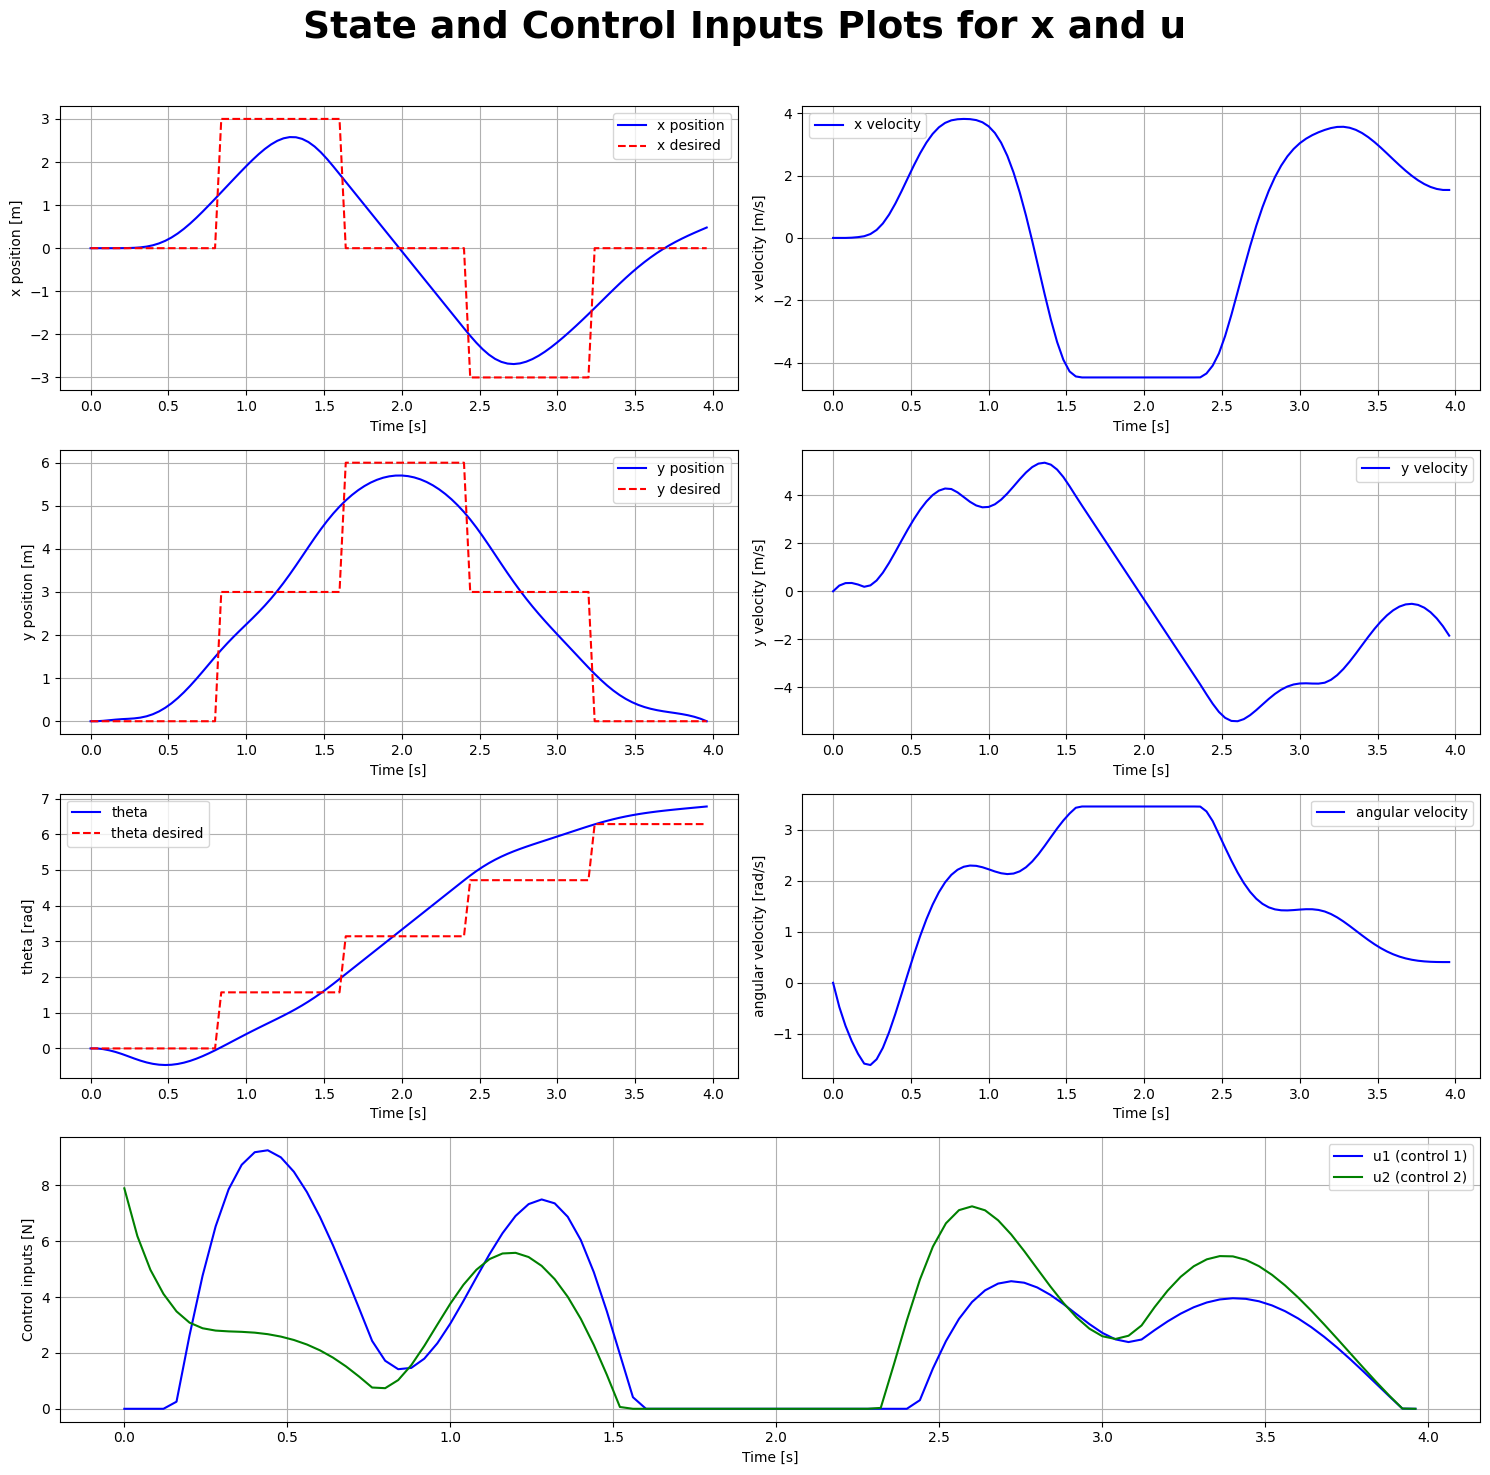

In [16]:
# Set the figure size
x_figsize = 15
y_figsize = 15

# Create a time array based on the number of columns in x
time = np.arange(x.shape[1]) * quadrotor.DT  # Multiply by DT to get actual time

# Create a time array for u
time_u = np.arange(u.shape[1]) * quadrotor.DT

iterations = 100
# Define desired states
cluster = iterations // 5
x_desired = np.zeros((6, x.shape[1]))

for i in range(x.shape[1]):
    if i <= cluster:
        x_desired[:, i] = np.array([0, 0, 0, 0, 0, 0])
    elif cluster < i <= cluster * 2:
        x_desired[:, i] = np.array([3, 0, 3, 0, np.pi / 2, 0])
    elif cluster * 2 < i <= cluster * 3:
        x_desired[:, i] = np.array([0, 0, 6, 0, np.pi, 0])
    elif cluster * 3 < i <= cluster * 4:
        x_desired[:, i] = np.array([-3, 0, 3, 0, 3 * np.pi / 2, 0])
    else:
        x_desired[:, i] = np.array([0, 0, 0, 0, 2 * np.pi, 0])

# Create a single figure with a custom GridSpec layout
fig = plt.figure(figsize=(x_figsize, y_figsize))
gs = GridSpec(4, 2, figure=fig)

# Plot x position
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, x[0, :], label='x position', color='blue')
ax1.plot(time, x_desired[0, :], label='x desired', color='red', linestyle='--')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('x position [m]')
ax1.legend()
ax1.grid(True)

# Plot x velocity
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, x[1, :], label='x velocity', color='blue')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('x velocity [m/s]')
ax2.legend()
ax2.grid(True)

# Plot y position
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time, x[2, :], label='y position', color='blue')
ax3.plot(time, x_desired[2, :], label='y desired', color='red', linestyle='--')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('y position [m]')
ax3.legend()
ax3.grid(True)

# Plot y velocity
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(time, x[3, :], label='y velocity', color='blue')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('y velocity [m/s]')
ax4.legend()
ax4.grid(True)

# Plot theta (orientation)
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(time, x[4, :], label='theta', color='blue')
ax5.plot(time, x_desired[4, :], label='theta desired', color='red', linestyle='--')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('theta [rad]')
ax5.legend()
ax5.grid(True)

# Plot angular velocity
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(time, x[5, :], label='angular velocity', color='blue')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('angular velocity [rad/s]')
ax6.legend()
ax6.grid(True)

# Plot control inputs (u1 and u2), spanning the last two columns
ax7 = fig.add_subplot(gs[3, :])
ax7.plot(time_u, u[0, :], label='u1 (control 1)', color='blue')
ax7.plot(time_u, u[1, :], label='u2 (control 2)', color='green')
ax7.set_xlabel('Time [s]')
ax7.set_ylabel('Control inputs [N]')
ax7.legend()
ax7.grid(True)

# Add a title to the entire figure
fig.suptitle("State and Control Inputs Plots for x and u", fontsize=27, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## <u> Part 2 - Model predictive control (MPC) (50 points)</u>
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law



<div style="border: none; padding: 1px; background-color: #333300;">

```python
    def controller(x, t):
        return np.zeros(2)
    
    x_init = np.array([0, 0, 0., 0 ,0, 0])
    horizon_length = 100
    t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
    quadrotor.animate_robot(state, u)

In [17]:
def controller(x_init: np.ndarray, timestep: int):
    # Define the prediction horizon
    iterations = 50
    x_init = x_init.reshape(-1, 1)
    x_guess = np.zeros([(xdim + udim) * iterations, 1])
    x_guess[0:(xdim)] = x_init  # Use the current state as the initial guess

    x, u = filter_linear_search(
        Xbar=x_guess,
        x_init=x_init,
        alpha=1,
        tol=1e-4,
        rho=0.5,
        iterations=iterations,
        timestep=timestep
    )

    next_state = quadrotor.next_state(
        x[:, 0].flatten(), u[:, 0].flatten())
    print(
        f"For k = {timestep}\n"
        f"    x_init  = {x[:, 0].flatten()}\n"
        f"    u = {u[:, 0].flatten()}\n"
        f"    Next State = {next_state}"
    )

    gc.collect()

    return u[:, 0].flatten()


In [18]:
horizon_length = 100  # Total simulation horizon length
x_init=np.zeros([6,1]).flatten()

t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)


Total iterations needed = 11
DEBUG POINT
For k = 0
    x_init  = [ 1.31162334e-17 -3.24352406e-18  5.89836471e-20  8.14828879e-11
  4.34722988e-16 -5.89849717e-15]
    u = [7.02070129e-13 8.03449753e+00]
    Next State = [ 1.29864924e-17 -2.82665986e-16  3.25931558e-12  2.50359802e-01
  1.98783101e-16 -4.82069852e-01]
Total iterations needed = 7
DEBUG POINT
For k = 1
    x_init  = [-4.75364341e-14 -4.59066043e-01  8.64215309e-09 -5.60894102e+00
  5.77509753e-05 -6.71598371e-01]
    u = [14.88872274 14.97137414]
    Next State = [-0.01836264 -0.459204   -0.22435763 -3.61253327 -0.02680618 -0.67655745]
Total iterations needed = 3
DEBUG POINT
For k = 2
    x_init  = [-1.03832844e-02 -2.59582111e-01 -4.46653609e-03  6.62725289e+00
 -1.37701287e-02 -3.84705668e-01]
    u = [6.47575273 6.45452179]
    Next State = [-0.02076657 -0.24533844  0.26062358  7.26917678 -0.02915836 -0.38343181]
Total iterations needed = 20
DEBUG POINT
For k = 3
    x_init  = [-0.02076019 -0.24379479  0.07096451  2.5

In [19]:
quadrotor.animate_robot(state, u)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAUQ1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Dz5liIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBfcP2iCGJiAS8DWjsJOZSvmmHq7RcN9EPY2BnDfe5YBvsK9wCVrqhDjw1B8/ii+rv
VJ5BfVzCy8odoO/V3L3nhFH09qhK/GR7+sJ4yheryyNik/rwNAJFX+MmVo4hZIWV9uvxTcXKwA3X
LuQgeVZsSu7Ul/PY2rN2TdRMNXbwmySUWBWBTPxFHl5bFxxA7zo8Yv8Syc/tlHNycu08C6wk7sV1
9ehL0bkzRX7OvXMxbP+AtX+ZAaoHAVqnP19a0QY5TATeGcE3NEGK4tWAAAADAABODtdeNilrzUmr
kfl0UwOvaHyH01WM88NQJBpRv6Ef6de5/ylHBu47f2zHJPIOiMDDLwskq1Bx7apCslFTEmPHdDtI
4N78HhY0FvJy0Uuw04UdShUffNLrSejvsrk6mf8+B1MTuweFV7b1nvPYo3vvYnms0K7v7yLaXIPu
ZwLo56wrDBOPomUHBQ4KHhKmHwGCKv++F3Z0v8DoVCl7cu29wz4NsZubXhN9OR/aZvfkUsjRdJiL
WrHDo4cR9i13BNJOyZGtoUMMFgnehvNyArxjqljL2U8qVKxsYZ+I5hbJiew33baLH/umrCywKf9A
QG8PSlxhnuk9EAUJ6JgUAkABdn6VrgCw94LG0NS+1xJIp4AA0bbM2WZ0o68vFc08UI1Eg2D3qQLa
5NhQAAADAAADAAOdsfJaZbAhtJCSc1VobnfItEkHWSPqQyZ7AAkwk0tUAcnW39CoBEKNMvt9b9Ji
pwQNIE5t1lQezzExyjNDBPCNc+SZFAblyrwKM/MFWi+/l5K/NM4/DWPRAjdr0YbSqRbz9kGW3/H3
Myt13btwn/UqFYDSerRUUrxpzoL7OahHBm94apfv6ml8COqNTnKJ850CKwf+AkhYRQVFfbo+2PyS
G9d9CoSnldIigp/3o8WVdbHhvAGSRR/kX+8zl4vUyvJovpNMx2I3YpXhMcjf//6Cdi+triwYGLpx
y8K5fTP0T5W7mhKM2y9SiFivsVOG7Vf+/xWmZpcvbKXS5BgzafZYMndYG8owooMA2jfmc+4AAQel
3pziF/5xhKW8B0OKGhZQ1gAAAwAAAwAADB6Z9rWuqNTaUViu2KDrynIhR2OMKO3VSxx2ttOrr93p
jg3L4+OPKqQU+qQz6i+C9zxC3RcdO0zoIxDfcfQBrZpJK9+k0RaZFo5vN8oPnc24M0XtqI3UpQkL
dDA6KPrnyYpAcG9kmi8uM6/RvK6pTr1iHf2+YMgkgBZo+AYS9ATVvCKkPoCn125rDl7aKDmkRiix
sm9zEd9iFYY3kGGpWZ5LaB6IMYuKzFz4YcDOoR0E2CrQGrvUSHtNdIgbFyvc/xT5hW5UkvOInM98
dhWWHIbHros48WNel73Evm3sQqHudRHkxyAE7mdfJ1GfToCKLzQBCancNDolm0v+SVczNFT/+t6l
7iVHfiIbcW9ONDVJtLuFYIMgp7yq/xDPvy6Bvzu6Sjb1xPIsURvED8lVgCL+S1DxOpH1lC9q/sal
Po7DZVWOiXAik4H2U7bwzFWDcqMltgrYHAmRgUqrL6FvSH5Z8/fDbhHCfLbHe7AUaGjKgta0uRsV
HhBo4HuKs4Ix8iKmy1THPEIH43ZEjyP0SizywAgIU97BdgvTk7aibZQQKAa5uROtmEXo7JG87T94
Wuv4kcTu67KX7wHR8JkdDoqg/SjmKkTwrXQycE4MKpuBmz6xtV1rFK5gJuf4PlhVNON7v7HFdawT
Bq/ov21Uyz65zilsn1TTARDeuTwb/sGGQp/nrV7V7Bumm/4xVtly9s7M02VgGMM+lw94j53Veh2e
MVS5jirPN1Dz01X875oozBZRk2MYhZ1P/780wwHj/wNltsO3Am3eAVK8nY5o1l8TzFLk/h0Qiuxv
ulUKnM3HQxgQrk2T9/o15PmfxXDHfsvB2bPjvfbB5xrySw8SMrv3YLSDs9GclktPUcYGUHnoGJX0
s72j899KV9+Udw5lFRORrX1uo0Kstd7pd9fwgBSQnV9opN4r9VmnKoQ+LMgEx19PpbOlD4IRe2oZ
WFxy5I/+vA/sFe9PHLTKKnVIbQmY/nTL7eMKP7aKioWn5Bjz8xoudbRE5gTA4kUYdJ0LH4nKozEu
UWk9JxbRD+BMpKTfNHic7F9tfpXq5LkRNha2pG3pWi/3wH74+rYw9X6soluXzaUHIP4oGeVX2ScC
YnKKmArOFdWHlziUG9zPfZNpZCYfleEyqFTHL7hTjijqMW0h8vTjagr8YrjUG6aWLuq23o9qNHfC
9mY5ASk4B+8ZD9k7B601J9eHb97TLtSv0qaB8GHW6gQAAAMAAAMAAAMAAAc6jM+a7o9+txe854Wz
hYTb3pLgaT5IaY27fRzxhNR1AZ8+TaItnsWqQYs8FAfvv8YIrIxqmhzfO1v8JgfzlS4SuR90UnG+
b4YQStttg++5h8KHxQX90qNZU2ebVURVB+iqwJLkw1MHLYaDIPb+8jTsF/TeQyxo5KmGvQ/KRKl7
MNB7510AsFAnXhWUayHdbbn7bsnQgim0DYgrJfG/9PzewbAzAIEOyJUaoTjXOb03Vsod7MJ9s0yS
cvef6jFnikIlA10TocmGmKewidF+f+VGpBZ41Oiumv4mMPirJq8HE5b61tzPkRSg74KwJ1TcX+2G
kaF/HZSWoVjQSih9KQdftGsK/BPpPLLsyrvoHrMphcxDSQAZ/2lRgSaZo/JiKLu5NPmezZ4034Og
UfmsWEuuJUjg9g3CEHyE6aMfULI6W4/CrZEdTfIy2hXmrWyc1+jtu135kqTZcT+8OiYYvElwoa80
UsuFIlBxkxfA7KgxQcLgV

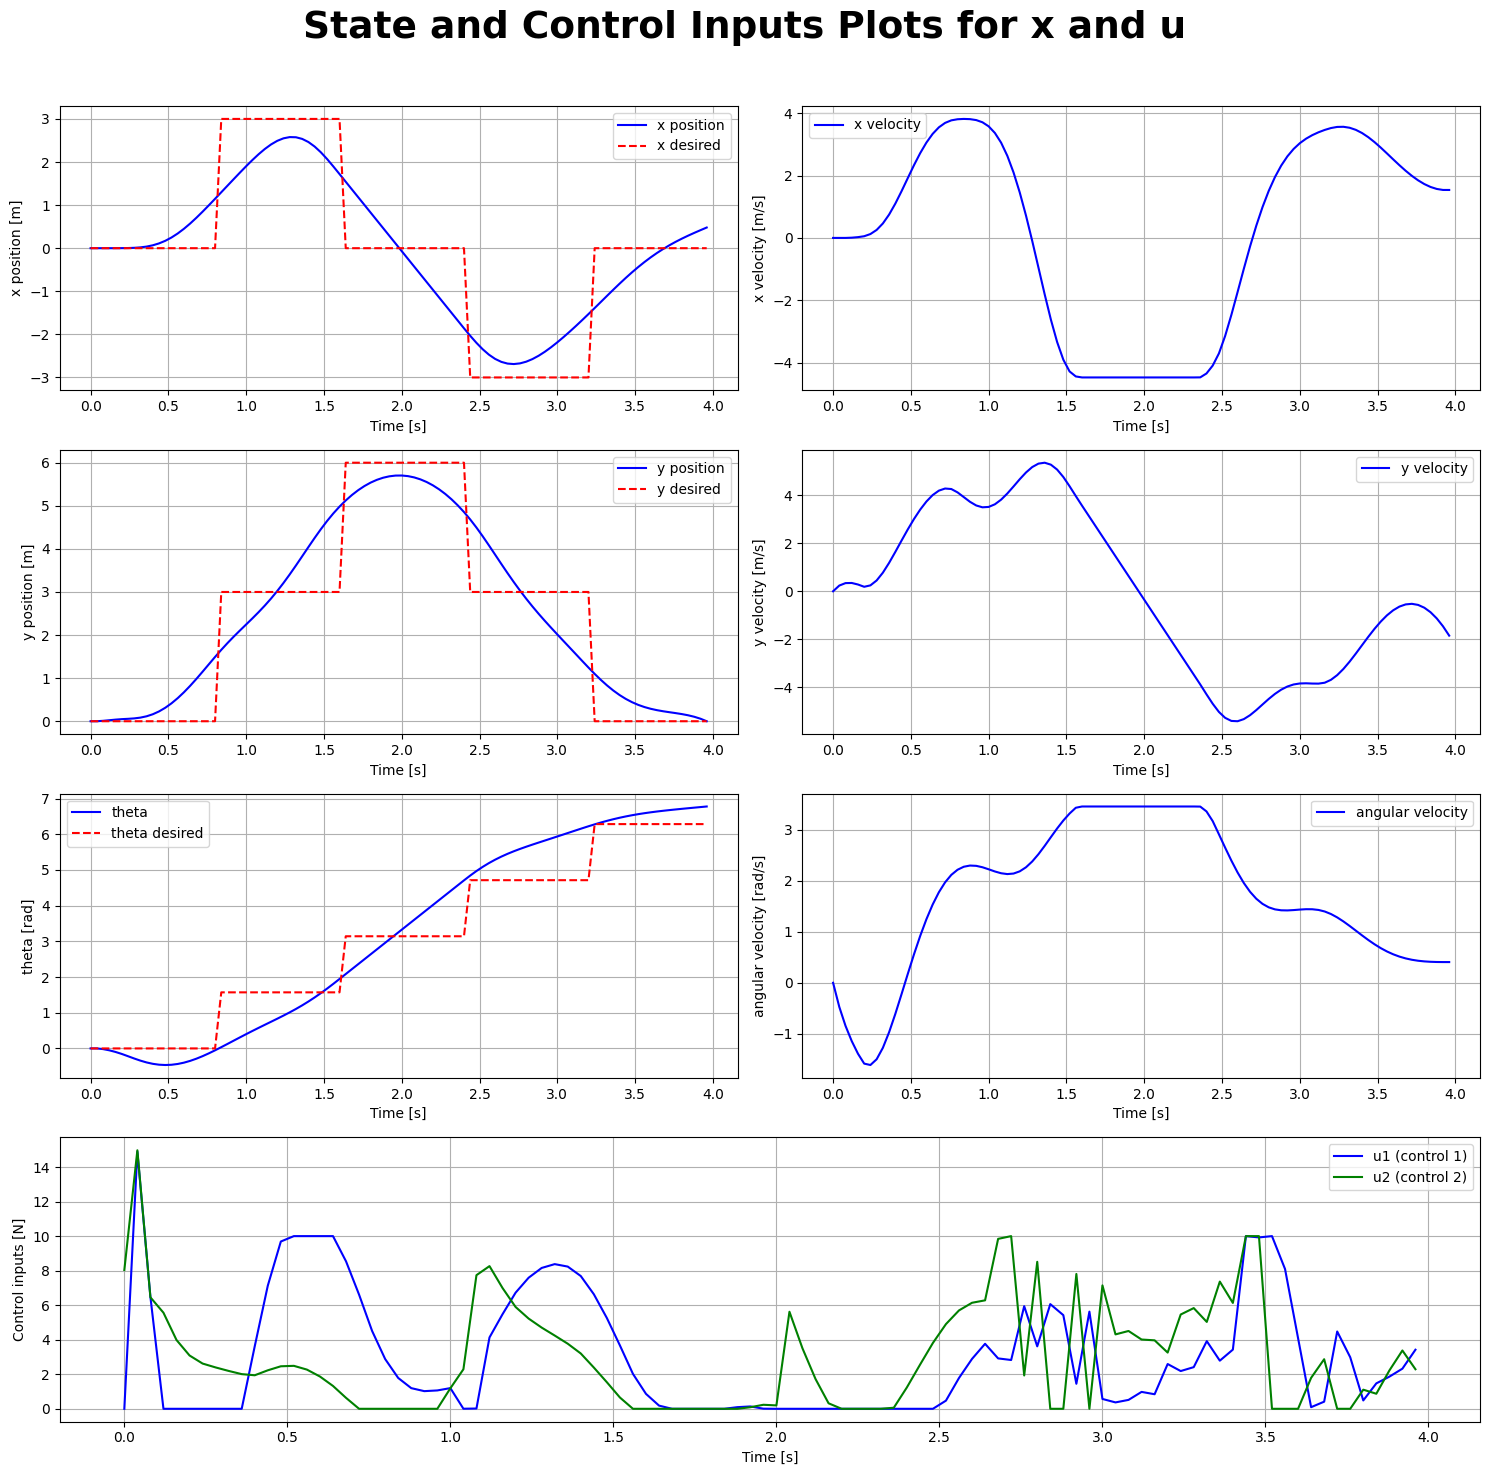

In [21]:
# Set the figure size
x_figsize = 15
y_figsize = 15

# Create a time array based on the number of columns in x
time = np.arange(x.shape[1]) * quadrotor.DT  # Multiply by DT to get actual time

# Create a time array for u
time_u = np.arange(u.shape[1]) * quadrotor.DT

# Define desired states
cluster = 100 // 5
x_desired = np.zeros((6, x.shape[1]))

for i in range(x.shape[1]):
    if i <= cluster:
        x_desired[:, i] = np.array([0, 0, 0, 0, 0, 0])
    elif cluster < i <= cluster * 2:
        x_desired[:, i] = np.array([3, 0, 3, 0, np.pi / 2, 0])
    elif cluster * 2 < i <= cluster * 3:
        x_desired[:, i] = np.array([0, 0, 6, 0, np.pi, 0])
    elif cluster * 3 < i <= cluster * 4:
        x_desired[:, i] = np.array([-3, 0, 3, 0, 3 * np.pi / 2, 0])
    else:
        x_desired[:, i] = np.array([0, 0, 0, 0, 2 * np.pi, 0])

# Create a single figure with a custom GridSpec layout
fig = plt.figure(figsize=(x_figsize, y_figsize))
gs = GridSpec(4, 2, figure=fig)

# Plot x position
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time, x[0, :], label='x position', color='blue')
ax1.plot(time, x_desired[0, :], label='x desired', color='red', linestyle='--')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('x position [m]')
ax1.legend()
ax1.grid(True)

# Plot x velocity
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time, x[1, :], label='x velocity', color='blue')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('x velocity [m/s]')
ax2.legend()
ax2.grid(True)

# Plot y position
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(time, x[2, :], label='y position', color='blue')
ax3.plot(time, x_desired[2, :], label='y desired', color='red', linestyle='--')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('y position [m]')
ax3.legend()
ax3.grid(True)

# Plot y velocity
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(time, x[3, :], label='y velocity', color='blue')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('y velocity [m/s]')
ax4.legend()
ax4.grid(True)

# Plot theta (orientation)
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(time, x[4, :], label='theta', color='blue')
ax5.plot(time, x_desired[4, :], label='theta desired', color='red', linestyle='--')
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('theta [rad]')
ax5.legend()
ax5.grid(True)

# Plot angular velocity
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(time, x[5, :], label='angular velocity', color='blue')
ax6.set_xlabel('Time [s]')
ax6.set_ylabel('angular velocity [rad/s]')
ax6.legend()
ax6.grid(True)

# Plot control inputs (u1 and u2), spanning the last two columns
ax7 = fig.add_subplot(gs[3, :])
ax7.plot(time_u, u[0, :], label='u1 (control 1)', color='blue')
ax7.plot(time_u, u[1, :], label='u2 (control 2)', color='green')
ax7.set_xlabel('Time [s]')
ax7.set_ylabel('Control inputs [N]')
ax7.legend()
ax7.grid(True)

# Add a title to the entire figure
fig.suptitle("State and Control Inputs Plots for x and u", fontsize=27, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
